In [1]:
from datetime import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import gcsfs

List all the NetCDF files that we have on the system that we want to process.

In [25]:
# get all *.nc files
ncfiles = [f for f in glob.glob('ncfiles/*.nc')]

# sort by start year
ncfiles.sort(key = lambda x: x.split('.')[-2][:4])

ncfiles

['ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1970010100-1979123100.nc',
 'ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1980010100-1989123100.nc',
 'ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1990010100-1999123100.nc',
 'ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.2000010100-2009123100.nc',
 'ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.2010010100-2014123100.nc']

Load the first file as an Xarray Dataset

In [26]:
ds = xr.open_dataset(ncfiles[0])

Remove variables that we don't need and rechunk the data

In [27]:
ds_ivt = ds[['IVT']]
ds_ivt['IVT'] = ds_ivt['IVT'].astype('float16')
ds_ivt = ds_ivt.chunk({'time': 1000, 'lat': 192, 'lon': 288})
ds_ivt

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 14600, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 117kB 1970-01-01 00:00:00 ... 1979-12-31 18:00:00
Data variables:
    IVT      (time, lat, lon) float16 2GB dask.array<chunksize=(1000, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BHISTsmbb.f09_g17.LE2-1111.006
    logname:           sunseon
    host:              mom2
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1111-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_6

Save as a zarr store in an existing GCP bucket. 

In [28]:
zarr_store = 'gs://cesm2/ivt.zarr'
ds_ivt.to_zarr(zarr_store, mode='w')

In [29]:
ds_zarr = xr.open_zarr(zarr_store, consolidated=False)
print(f'Variable size: {ds_zarr.nbytes/1e9:.1f} GB')

Variable size: 1.6 GB


In [30]:
ds_zarr.time.min()

<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)

In [31]:
ds_zarr.time.max()

<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(1979, 12, 31, 18, 0, 0, 0, has_year_zero=True),
      dtype=object)

Append each of the other netcdfs to the zarr store.

In [38]:
for f in ncfiles[1:]:
    print(f'Processing: {f}')
    
    # open the dataset
    print('\tOpening dataset... ', end='')
    ds = xr.open_dataset(f)
    print('done')

    # subset and rechunk
    print('\tRechunking... ', end='')
    ds_ivt = ds[['IVT']]
    ds_ivt['IVT'] = ds_ivt['IVT'].astype('float16')
    ds_ivt = ds_ivt.chunk({'time': 1000, 'lat': 192, 'lon': 288})
    print('done')

    # append to zarr store
    print('\tAppending to Zarr Store... ', end='')
    zarr_store = 'gs://cesm2/ivt.zarr'
    ds_ivt.to_zarr(zarr_store, append_dim='time' , mode='a')
    print('done')


Processing: ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1990010100-1999123100.nc
	Opening dataset... done
	Rechunking... done
	Appending to Zarr Store... done
Processing: ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.2000010100-2009123100.nc
	Opening dataset... done
	Rechunking... done
	Appending to Zarr Store... done
Processing: ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.2010010100-2014123100.nc
	Opening dataset... done
	Rechunking... 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10afab0e0>>
Traceback (most recent call last):
  File "/Users/castro/Documents/work/notebooks/data-processing/cesm2/conda-env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



Open the updated zarr store

In [39]:
zarr_store = 'gs://cesm2/ivt.zarr'
ds_zarr = xr.open_zarr(zarr_store, consolidated=False)
print(f'Variable size: {ds_zarr.nbytes/1e9:.1f} GB')

Variable size: 6.5 GB


In [40]:
ds_zarr.time.min()

<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(1970, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)

In [41]:
ds_zarr.time.max()

<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(2009, 12, 31, 18, 0, 0, 0, has_year_zero=True),
      dtype=object)

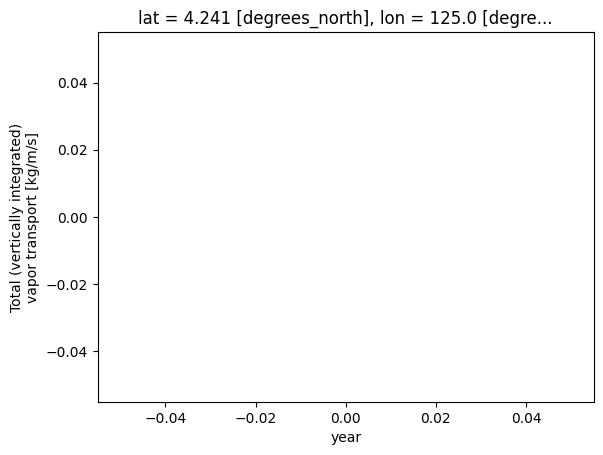

In [42]:
ds_zarr.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(label='zarr', color='b', linestyle='--')
ds_zarr.IVT.groupby('time.year').sum().isel(lat=100,lon=100).plot(color='g', linestyle='--', marker='x')